In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import math

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import os

from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.layers import Input, Dense, Dropout, BatchNormalization, AlphaDropout
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import AdamW

import statsmodels.api as sm
from statsmodels.formula.api import ols

import pickle as pkl

In [10]:
NHL_ALLSHOTS_DF = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\NHL_Shots_2013-2022.csv")
NHL_ALLSHOTS_DF.columns

Index(['Game_Id', 'Date', 'Period', 'Seconds_Elapsed', 'Game_Seconds', 'p1_ID',
       'Event', 'xC', 'yC', 'xC -1', 'yC -1', 'Time_Diff', 'Is_Rebound',
       'Is_Flurry', 'Off_Rush', 'Off_FO_Win', 'Off_Takeaway', 'Off_Giveaway',
       'BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN',
       'WRAP-AROUND', 'WRIST SHOT', 'Even_Strength', 'Power_Play',
       'Short_Handed', 'Is_Goal', 'empty_net_shot', 'Handedness', 'xC_adj',
       'yC_adj', 'xC_adj -1', 'yC_adj -1', 'Strong_Side_Shot', 'season_id',
       'Shot_Distance', 'Shot_Angle', 'last_event_dist',
       'dist_per_sec_last_event', 'Below_goal_line', 'Royal_Road'],
      dtype='object')

In [11]:
#Tweaks make before modeling.

NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[NHL_ALLSHOTS_DF['xC_adj']>25]
NHL_ALLSHOTS_DF['Shot_Angle2'] = (NHL_ALLSHOTS_DF['Shot_Angle']-90) *-1
#NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[NHL_ALLSHOTS_DF['empty_net_shot']==0]
NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[NHL_ALLSHOTS_DF['Even_Strength']==1]
#NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[NHL_ALLSHOTS_DF['season_id']>=2017]
NHL_ALLSHOTS_DF['yC_adj -1'] = NHL_ALLSHOTS_DF['yC_adj -1'].fillna(0)
NHL_ALLSHOTS_DF['xC_adj -1'] = NHL_ALLSHOTS_DF['xC_adj -1'].fillna(0)
NHL_ALLSHOTS_DF['Shot_Distance2'] = 1/NHL_ALLSHOTS_DF['Shot_Distance'].fillna(0)
NHL_ALLSHOTS_DF['Pads_changed'] = NHL_ALLSHOTS_DF['season_id']>=2018
NHL_ALLSHOTS_DF['Pads_changed'] = NHL_ALLSHOTS_DF['Pads_changed'].astype(int)
#NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[NHL_ALLSHOTS_DF['Power_Play']==1]

NHL_ALLSHOTS_DF

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,p1_ID,Event,xC,yC,xC -1,...,season_id,Shot_Distance,Shot_Angle,last_event_dist,dist_per_sec_last_event,Below_goal_line,Royal_Road,Shot_Angle2,Shot_Distance2,Pads_changed
0,20001,2013-10-01,1,74.0,74.0,8471742.0,MISS,35.0,-28.0,0.0,...,2013,60.827625,27.407575,44.821870,0.604884,0,0,62.592425,0.016440,0
1,20001,2013-10-01,1,96.0,96.0,8475848.0,SHOT,-82.0,-22.0,35.0,...,2013,23.086793,72.349876,117.153745,5.301074,0,0,17.650124,0.043315,0
2,20001,2013-10-01,1,144.0,144.0,8471504.0,SHOT,-44.0,-5.0,-20.0,...,2013,45.276926,6.340192,29.410882,2.430651,0,0,83.659808,0.022086,0
3,20001,2013-10-01,1,148.0,148.0,8470324.0,SHOT,-56.0,-38.0,-69.0,...,2013,50.328918,49.028264,20.615528,6.650170,0,0,40.971736,0.019869,0
4,20001,2013-10-01,1,178.0,178.0,8474037.0,SHOT,55.0,-5.0,51.0,...,2013,34.365681,8.365886,44.181444,21.038783,0,1,81.634114,0.029099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085877,21213,2023-04-01,3,813.0,4813.0,8481122.0,SHOT,-36.0,-2.0,-69.0,...,2022,53.037722,2.161079,38.587563,18.375030,0,0,87.838921,0.018855,1
1085880,21213,2023-04-01,3,946.0,4946.0,8475764.0,MISS,-44.0,1.0,-97.0,...,2022,45.011110,1.273030,53.000000,2.398190,0,0,88.726970,0.022217,1
1085881,21213,2023-04-01,3,953.0,4953.0,8476913.0,SHOT,83.0,5.0,-44.0,...,2022,7.810250,39.805571,127.062977,17.896194,0,0,50.194429,0.128037,1
1085882,21213,2023-04-01,3,981.0,4981.0,8476967.0,SHOT,40.0,1.0,69.0,...,2022,49.010203,1.169139,35.805028,1.321219,0,0,88.830861,0.020404,1


In [12]:
y = NHL_ALLSHOTS_DF['Is_Goal']

#x = NHL_ALLSHOTS_DF[['Shot_Distance','Shot_Angle2','WRIST SHOT','WRAP-AROUND','TIP-IN','SNAP SHOT','SLAP SHOT','DEFLECTED','BACKHAND','Off_Giveaway','Off_Takeaway','Off_Rush','Is_Rebound','Is_Flurry','Power_Play','Short_Handed','empty_net_shot','dist_per_sec_last_event','Royal_Road','Below_goal_line','Off_FO_Win','Period','Seconds_Elapsed']]
x = NHL_ALLSHOTS_DF[['Shot_Distance', 'Shot_Angle2','WRIST SHOT','WRAP-AROUND','TIP-IN','SNAP SHOT','SLAP SHOT','DEFLECTED','BACKHAND','Off_Giveaway','Off_Takeaway','Off_Rush','Is_Rebound','Is_Flurry','Short_Handed','empty_net_shot','dist_per_sec_last_event','Royal_Road','Below_goal_line','Off_FO_Win','Period','Seconds_Elapsed', 'yC_adj', 'yC_adj -1', 'Pads_changed', 'Strong_Side_Shot', 'Power_Play']]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [14]:
model_logit = LogisticRegression(fit_intercept=False, penalty='l2',C=0.1 ,max_iter=200, solver='liblinear')
model_logit.fit(x_train,y_train)

y_pred_logit = model_logit.predict_proba(x_test)

#accuracy_logit = accuracy_score(y_test, y_pred_logit)
#f1_logit = f1_score(y_test, y_pred_logit)
#precision_logit = precision_score(y_test, y_pred_logit)
#recall_logit = recall_score(y_test, y_pred_logit)

#print(f'Accuracy is {accuracy_logit}')
#print(f'F1 score is {f1_logit}')
#print(f'Precision Score is {precision_logit}')
#print(f'Recall is {recall_logit}')


In [15]:
#predict proba returns a dictionary with two probabilities (probability of no goal and of a goal). I only want the probability of the shot being a goal.

y_pred_logit = model_logit.predict_proba(x_test)

y_pred_logit_ex = []
for i in range(len(y_pred_logit)):
    y_pred_logit_ex.append(y_pred_logit[i][1])

#y_test_xG_values

In [16]:
auc_logit = roc_auc_score(y_test, y_pred_logit_ex)
print(f'Area Under Curve is {auc_logit}')

Area Under Curve is 0.7690857160083006


In [17]:
print(np.sum(y_test))
print(np.sum(y_pred_logit_ex))

5507
5574.002917309522


In [18]:
abs(np.sum(y_test)-np.sum(y_pred_logit_ex))/np.sum(y_test)

0.012166863502727759

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
model_boost = HistGradientBoostingRegressor(random_state=1, warm_start=True, max_depth=10, max_leaf_nodes=50, min_samples_leaf=250, loss='poisson')
#model_boost = HistGradientBoostingClassifier(random_state=42, warm_start=True, loss='binary_crossentropy', max_iter=400, max_depth=10, max_leaf_nodes=100, min_samples_leaf=250)


In [20]:
model_boost.fit(x_train,y_train)

y_pred_boost = model_boost.predict(x_test)
y_pred_boost

array([0.01392158, 0.1469194 , 0.04744348, ..., 0.03674715, 0.04749145,
       0.06213336])

In [21]:
auc_boost = roc_auc_score(y_test, y_pred_boost)
print(f'Area Under Curve is {auc_boost}')

Area Under Curve is 0.7809496083411889


In [22]:
print(np.sum(y_test))
print(np.sum(y_pred_boost))

5507
5517.471392969913


In [23]:
abs(np.sum(y_test)-np.sum(y_pred_boost))/np.sum(y_test)

0.0019014695787021633

In [296]:
#model_boost.save_model('xG_model_Gradient_Boost')

pkl.dump(model_boost, open('C:\\Users\\jorda\\Documents\\Concordia Boot Camp\\Lectures\\model_boost_xG.pkl', 'wb'))

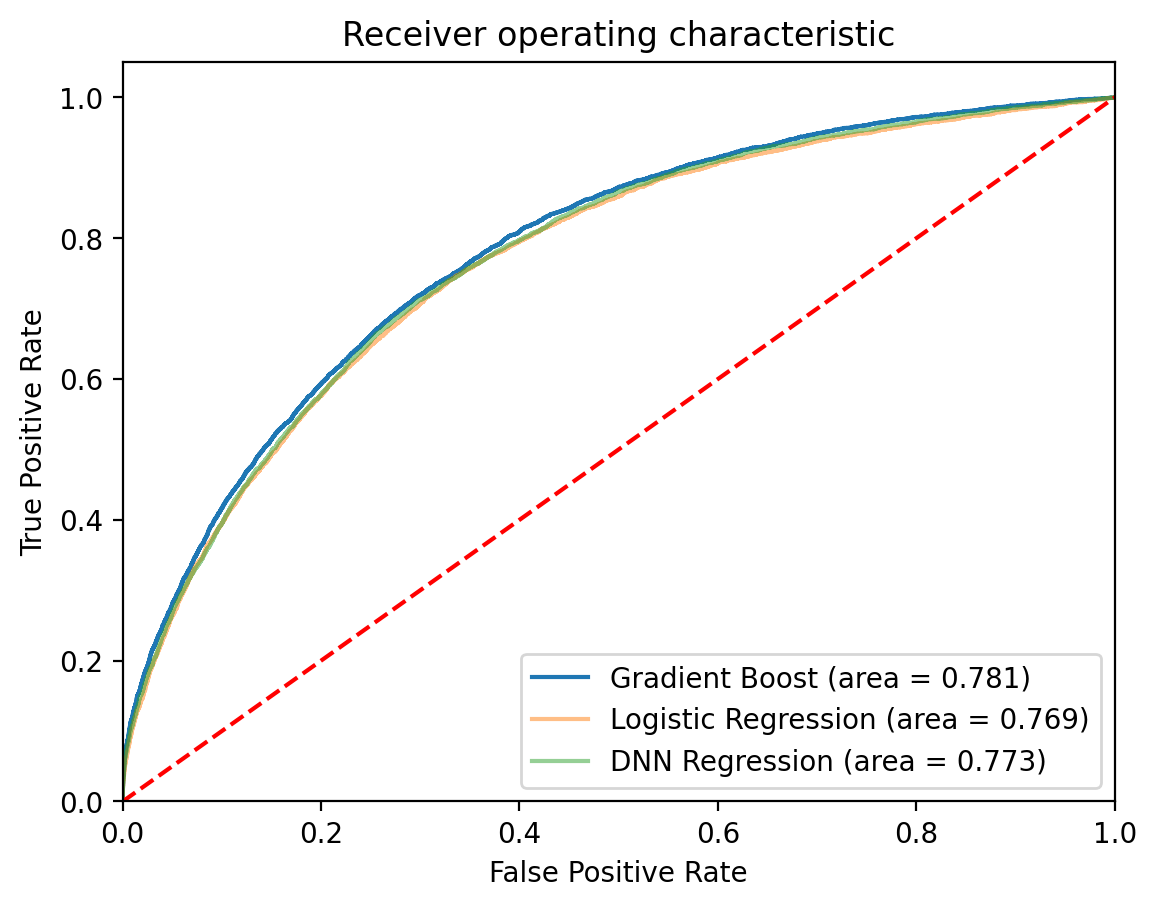

In [57]:
boost_roc_auc = roc_auc_score(y_test, y_pred_boost)
logit_roc_auc = roc_auc_score(y_test, y_pred_logit_ex)
NN_roc_auc = roc_auc_score(y_test, y_pred_NN)
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, y_pred_boost)
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, y_pred_logit_ex)
fpr_NN, tpr_NN, thresholds_logit = roc_curve(y_test, y_pred_NN)


plt.figure(dpi=200)
plt.plot(fpr_boost, tpr_boost, label='Gradient Boost (area = %0.3f)' % boost_roc_auc, alpha=1)
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.3f)' % logit_roc_auc, alpha=0.5)
plt.plot(fpr_NN, tpr_NN, label='DNN Regression (area = %0.3f)' % NN_roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.grid(True)
plt.grid(color='white')
plt.set_facecolor((0.92,0.92,0.95))
plt.show()

In [32]:
# The reason for this version of the model is that it can return variable importance metrics. HistGradientBoostingRegressor is used otherwise for the benifits in time complexity.

model_boost_ff = GradientBoostingRegressor(random_state=1, warm_start=True, max_depth=10, max_leaf_nodes=50, min_samples_leaf=250, loss='squared_error')
model_boost_ff.fit(x_train,y_train)
#y_pred_boost_ff = model_boost.predict(x_test)

feature_important = model_boost_ff.feature_importances_
columns = x.columns
feature_important_decimal = []
for i in feature_important:
    feature_important_decimal.append(float(i))

importance_dict = dict(zip(columns,feature_important_decimal))


In [33]:
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
importance_dict

{'Shot_Distance': 0.3592015342838509,
 'empty_net_shot': 0.2469775606518132,
 'Shot_Angle2': 0.08495014571604882,
 'Is_Rebound': 0.0635266912893334,
 'dist_per_sec_last_event': 0.06183111188780592,
 'Royal_Road': 0.03331101362941743,
 'Off_Giveaway': 0.022308441681123,
 'SNAP SHOT': 0.01719712032740489,
 'WRIST SHOT': 0.013875693159373339,
 'yC_adj -1': 0.013515926939051326,
 'Seconds_Elapsed': 0.01021490609415572,
 'BACKHAND': 0.009904745270126365,
 'yC_adj': 0.008051276166941195,
 'Strong_Side_Shot': 0.007684732959545394,
 'WRAP-AROUND': 0.007666005929077364,
 'SLAP SHOT': 0.006853670530773525,
 'Pads_changed': 0.006456613931587584,
 'TIP-IN': 0.005446863228257575,
 'Period': 0.005049190436471476,
 'DEFLECTED': 0.004794577316244141,
 'Is_Flurry': 0.004108009930119493,
 'Off_Takeaway': 0.004000572731575176,
 'Off_Rush': 0.0019554756667162975,
 'Off_FO_Win': 0.0006497895216205284,
 'Below_goal_line': 0.0004683307215660726,
 'Short_Handed': 0.0,
 'Power_Play': 0.0}

In [34]:
y_pred_boost_nn = model_boost_ff.predict(x_test)

auc_boost_ff = roc_auc_score(y_test, y_pred_boost)
print(f'Area Under Curve is {auc_boost_ff}')

Area Under Curve is 0.7809496083411889


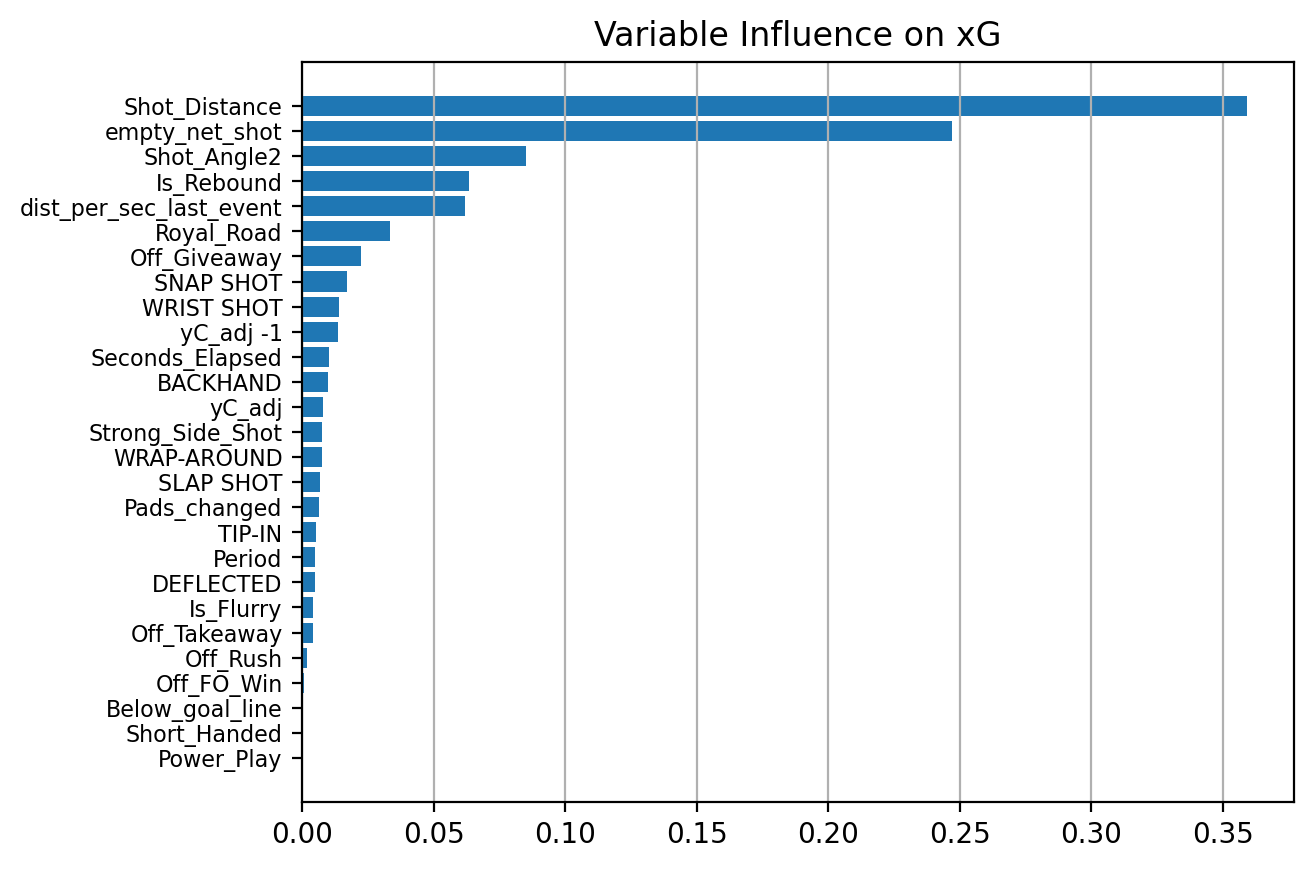

In [73]:
labels = importance_dict.keys()
fig, ax = plt.subplots(dpi=200)
ax.barh(range(len(importance_dict)), importance_dict.values(), align='center')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])
ax.set_yticklabels(labels, size=8)
plt.title('Variable Influence on xG')
plt.gca().xaxis.grid(True)
plt.gca().invert_yaxis()

In [297]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [40]:
model = keras.Sequential()

tf.keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None)

model.add(Dense(256,activation='relu', kernel_initializer='normal', input_dim=27))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))


                
optimizer = AdamW(learning_rate=0.001)
#optimizer = SGD(learning_rate=0.001)
#optimizer = RMSprop(learning_rate=0.001)
                
model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=tf.keras.metrics.AUC(
    num_thresholds=400,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
))
               

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               7168      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40,193
Trainable params: 40,193
Non-trainable params: 0
_________________________________________________________________


In [41]:
attempt1 = model.fit(x_train, y_train, epochs = 30, batch_size = 2048, validation_split = 0.20)

Epoch 1/30
307/307 [==============================] - 4s 11ms/step - loss: 0.5959 - auc_1: 0.5838 - val_loss: 0.2211 - val_auc_1: 0.7169
Epoch 2/30
307/307 [==============================] - 3s 10ms/step - loss: 0.2329 - auc_1: 0.6740 - val_loss: 0.2183 - val_auc_1: 0.7283
Epoch 3/30
307/307 [==============================] - 3s 10ms/step - loss: 0.2259 - auc_1: 0.6940 - val_loss: 0.2146 - val_auc_1: 0.7345
Epoch 4/30
307/307 [==============================] - 3s 11ms/step - loss: 0.2224 - auc_1: 0.7055 - val_loss: 0.2136 - val_auc_1: 0.7416
Epoch 5/30
307/307 [==============================] - 3s 10ms/step - loss: 0.2201 - auc_1: 0.7132 - val_loss: 0.2118 - val_auc_1: 0.7468
Epoch 6/30
307/307 [==============================] - 3s 10ms/step - loss: 0.2181 - auc_1: 0.7203 - val_loss: 0.2108 - val_auc_1: 0.7515
Epoch 7/30
307/307 [==============================] - 3s 10ms/step - loss: 0.2166 - auc_1: 0.7254 - val_loss: 0.2108 - val_auc_1: 0.7551
Epoch 8/30
307/307 [=====================

In [43]:
y_pred_NN = model.predict(x_test)

2726/2726 [==============================] - 2s 622us/step


In [44]:
y_pred_NN

array([[0.01579525],
       [0.1169133 ],
       [0.04458642],
       ...,
       [0.03277584],
       [0.02625511],
       [0.05722506]], dtype=float32)

In [45]:
y_test.shape

(87225,)

In [46]:
auc_logit = roc_auc_score(y_test, y_pred_NN)
print(f'Area Under Curve is {auc_logit}')

Area Under Curve is 0.7726794080950341


In [47]:
print(np.sum(y_test))
print(np.sum(y_pred_NN))

5507
4925.1094


In [48]:
abs(np.sum(y_test)-np.sum(y_pred_NN))/np.sum(y_test)

0.10566381423642637

In [24]:
xG_Values = model_boost.predict(x)
xG_Values

array([0.00567229, 0.0222392 , 0.02232002, ..., 0.24311233, 0.03005048,
       0.14942514])

In [25]:
NHL_ALLSHOTS_DF['xG'] = xG_Values
NHL_ALLSHOTS_DF

,Game_Id,Date,Period,Seconds_Elapsed,Game_Seconds,p1_ID,Event,xC,yC,xC -1,...,Shot_Distance,Shot_Angle,last_event_dist,dist_per_sec_last_event,Below_goal_line,Royal_Road,Shot_Angle2,Shot_Distance2,Pads_changed,xG
0,20001,2013-10-01,1,74.0,74.0,8471742.0,MISS,35.0,-28.0,0.0,...,60.827625,27.407575,44.821870,0.604884,0,0,62.592425,0.016440,0,0.005672
1,20001,2013-10-01,1,96.0,96.0,8475848.0,SHOT,-82.0,-22.0,35.0,...,23.086793,72.349876,117.153745,5.301074,0,0,17.650124,0.043315,0,0.022239
2,20001,2013-10-01,1,144.0,144.0,8471504.0,SHOT,-44.0,-5.0,-20.0,...,45.276926,6.340192,29.410882,2.430651,0,0,83.659808,0.022086,0,0.022320
3,20001,2013-10-01,1,148.0,148.0,8470324.0,SHOT,-56.0,-38.0,-69.0,...,50.328918,49.028264,20.615528,6.650170,0,0,40.971736,0.019869,0,0.007022
4,20001,2013-10-01,1,178.0,178.0,8474037.0,SHOT,55.0,-5.0,51.0,...,34.365681,8.365886,44.181444,21.038783,0,1,81.634114,0.029099,0,0.019568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085877,21213,2023-04-01,3,813.0,4813.0,8481122.0,SHOT,-36.0,-2.0,-69.0,...,53.037722,2.161079,38.587563,18.375030,0,0,87.838921,0.018855,1,0.036817
1085880,21213,2023-04-01,3,946.0,4946.0,8475764.0,MISS,-44.0,1.0,-97.0,...,45.011110,1.273030,53.000000,2.398190,0,0,88.726970,0.022217,1,0.039388
1085881,21213,2023-04-01,3,953.0,4953.0,8476913.0,SHOT,83.0,5.0,-44.0,...,7.810250,39.805571,127.062977,17.896194,0,0,50.194429,0.128037,1,0.243112
1085882,21213,2023-04-01,3,981.0,4981.0,8476967.0,SHOT,40.0,1.0,69.0,...,49.010203,1.169139,35.805028,1.321219,0,0,88.830861,0.020404,1,0.030050


In [26]:
NHL_ALLSHOTS_DF = NHL_ALLSHOTS_DF[['Game_Id', 'Date', 'Period', 'Seconds_Elapsed', 'p1_ID', 'Event', 'xG','Is_Rebound','Off_Rush','Off_FO_Win','Off_Takeaway','DEFLECTED','Shot_Distance','Royal_Road']]

AttributeError: 'Rectangle' object has no property 'title'

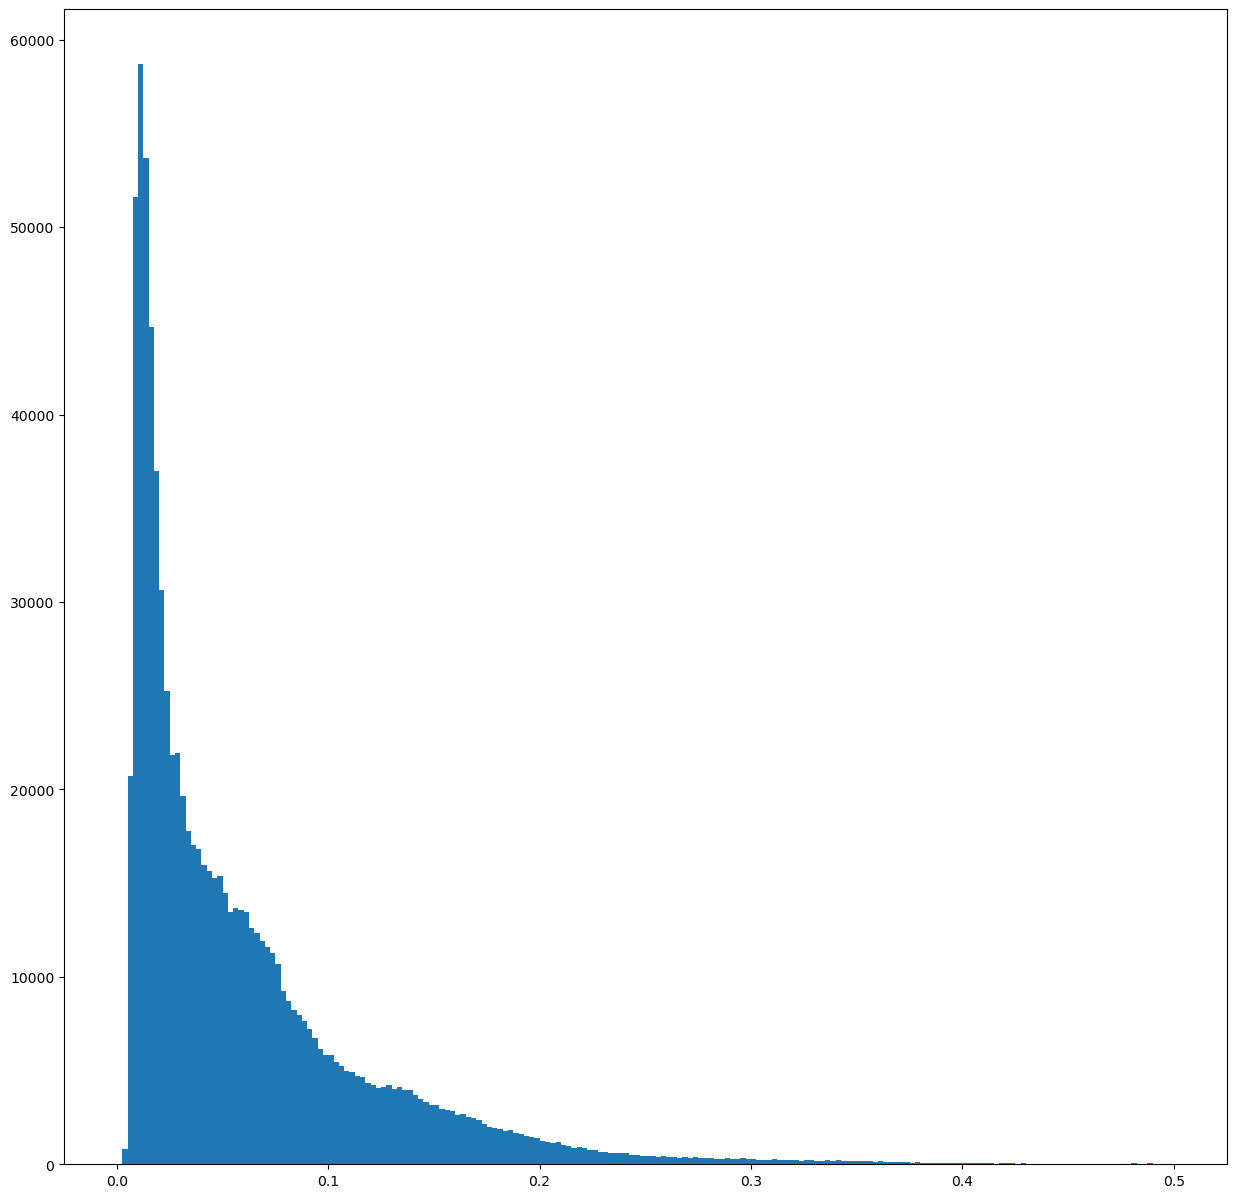

In [30]:
NHL_ALLSHOTS_DF.hist(column='xG', grid=True, range=[0,0.5], bins=200, figsize=(15,15), title='Distribution of xG Values')

In [325]:
NHL_ALLSHOTS_DF.to_csv('NHL_Shots_with_xG.csv', index=False)

In [5]:
NHL_PLAYER_METRICS = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\NHL_Player_Metrics_PBP.csv")
NHL_PLAYER_METRICS = NHL_PLAYER_METRICS[NHL_PLAYER_METRICS['Games_Played']>=40]

NHL_PLAYER_METRICS['Goals'] = NHL_PLAYER_METRICS['Goals'].fillna(0)
NHL_PLAYER_METRICS['Total_Shot_Attempts'] = NHL_PLAYER_METRICS['Total_Shot_Attempts'].fillna(0)
NHL_PLAYER_METRICS['xG'] = NHL_PLAYER_METRICS['xG'].fillna(0)
#NHL_PLAYER_METRICS = NHL_PLAYER_METRICS.sort_values(by=['Season_id','Player_Id'], ascending=False, inplace = False)
#NHL_PLAYER_METRICS = NHL_PLAYER_METRICS.sort_values(by='Season_id', ascending=False)

NHL_PLAYER_METRICS = NHL_PLAYER_METRICS[['Player','Player_Id','Season_id','Games_Played','Total_Shot_Attempts','True_Shooting_Pct','Goals','xG','Actual_to_Expected_Goals']]
NHL_PLAYER_METRICS['intercept'] = 1



NHL_PLAYER_METRICS_pred = NHL_PLAYER_METRICS



NHL_PLAYER_METRICS_pred['Total_Shot_Attempts -1'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['Total_Shot_Attempts'].shift(1)
NHL_PLAYER_METRICS_pred['Total_Shot_Attempts -2'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['Total_Shot_Attempts'].shift(2)
NHL_PLAYER_METRICS_pred['Total_Shot_Attempts -3'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['Total_Shot_Attempts'].shift(3)
NHL_PLAYER_METRICS_pred['xG -1'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['xG'].shift(1)
NHL_PLAYER_METRICS_pred['xG -2'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['xG'].shift(2)
NHL_PLAYER_METRICS_pred['xG -3'] = NHL_PLAYER_METRICS_pred.groupby('Player_Id')['xG'].shift(3)

NHL_PLAYER_METRICS_pred = NHL_PLAYER_METRICS_pred[NHL_PLAYER_METRICS_pred['xG -3'].notna()]

NHL_PLAYER_METRICS_pred['intercept'] = 1

NHL_PLAYER_METRICS_pred

C:\Users\jorda\AppData\Local\Temp\ipykernel_20736\3334644117.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NHL_PLAYER_METRICS_pred['intercept'] = 1


,Player,Player_Id,Season_id,Games_Played,Total_Shot_Attempts,True_Shooting_Pct,Goals,xG,Actual_to_Expected_Goals,intercept,Total_Shot_Attempts -1,Total_Shot_Attempts -2,Total_Shot_Attempts -3,xG -1,xG -2,xG -3
3,JAROMIR JAGR,8448208,2016,80,290,0.051724138,15,20.482265,-5.482265,1,291.0,299.0,391.0,21.303809,19.523103,27.600303
34,SHANE DOAN,8462038,2016,74,232,0.025862069,6,13.308176,-7.308176,1,285.0,309.0,315.0,19.571735,18.470735,18.726120
39,JAROME IGINLA,8462042,2016,80,261,0.053639847,14,14.948009,-0.948009,1,337.0,347.0,452.0,17.885950,16.018765,26.353969
57,MATT CULLEN,8464989,2016,97,190,0.078947368,15,15.702362,-0.702362,1,225.0,179.0,235.0,14.099224,10.404332,14.204180
58,MATT CULLEN,8464989,2017,84,176,0.068181818,12,10.995311,1.004689,1,190.0,225.0,179.0,15.702362,14.099224,10.404332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9513,ILYA LYUBUSHKIN,8480950,2022,61,68,0.029411765,2,1.294056,0.705944,1,106.0,66.0,83.0,2.010718,0.908999,1.352798
9615,BLAKE LIZOTTE,8481481,2022,73,161,0.062111801,10,10.136826,-0.136826,1,159.0,76.0,153.0,10.499456,4.342283,8.604713
9674,KAAPO KAKKO,8481554,2022,74,201,0.084577114,17,15.486189,1.513811,1,144.0,133.0,199.0,9.567625,9.525168,9.707496
9681,JACK HUGHES,8481559,2022,72,508,0.076771654,39,34.006577,4.993423,1,292.0,258.0,214.0,18.216606,14.222644,14.951183


In [13]:
y = NHL_PLAYER_METRICS[['Goals']]
x_shots = NHL_PLAYER_METRICS[['intercept','Total_Shot_Attempts']]
x_xG = NHL_PLAYER_METRICS[['intercept','xG']]


model_shot_attempts = sm.OLS(y,x_shots)
results_shot_attempts = model_shot_attempts.fit()
model_shot_attempts_vals = results_shot_attempts.predict(x_shots)
print(results_shot_attempts.summary())

                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     7389.
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:12:41   Log-Likelihood:                -19241.
No. Observations:                5806   AIC:                         3.849e+04
Df Residuals:                    5804   BIC:                         3.850e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -2.5911    

In [14]:
model_xG = sm.OLS(y,x_xG)
results_xG = model_xG.fit()
model_xG_vals = results_xG.predict(x_xG)
print(results_xG.summary())

                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                 3.100e+04
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:12:42   Log-Likelihood:                -16262.
No. Observations:                5806   AIC:                         3.253e+04
Df Residuals:                    5804   BIC:                         3.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.0465      0.091    -11.509      0.0

In [15]:
y_pred = NHL_PLAYER_METRICS_pred['Goals']
#y_pred = pd.DataFrame(y_pred)
x_shots_pred = NHL_PLAYER_METRICS_pred[['intercept','Total_Shot_Attempts -1']]
x_xG_pred = NHL_PLAYER_METRICS_pred[['intercept','xG -1']]

x_xG_pred





,intercept,xG -1
3,1,21.303809
34,1,19.571735
39,1,17.885950
57,1,14.099224
58,1,15.702362
...,...,...
9513,1,2.010718
9615,1,10.499456
9674,1,9.567625
9681,1,18.216606


In [16]:
model_shot_attempts_pred = sm.OLS(y_pred, x_shots_pred)
results_shot_attempts_pred = model_shot_attempts_pred.fit()
model_shot_attempts_pred_vals = results_shot_attempts_pred.predict(x_shots_pred)
print(results_shot_attempts_pred.summary())

                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     1068.
Date:                Fri, 21 Apr 2023   Prob (F-statistic):          1.65e-196
Time:                        15:12:42   Log-Likelihood:                -9410.8
No. Observations:                2602   AIC:                         1.883e+04
Df Residuals:                    2600   BIC:                         1.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0

In [17]:
model_xG_pred = sm.OLS(y_pred, x_xG_pred)
results_xG_pred = model_xG_pred.fit()
model_xG_pred_vals = results_xG_pred.predict(x_xG_pred)
print(results_xG_pred.summary())

                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     3300.
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:12:43   Log-Likelihood:                -8792.3
No. Observations:                2602   AIC:                         1.759e+04
Df Residuals:                    2600   BIC:                         1.760e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0196      0.257      3.971      0.0

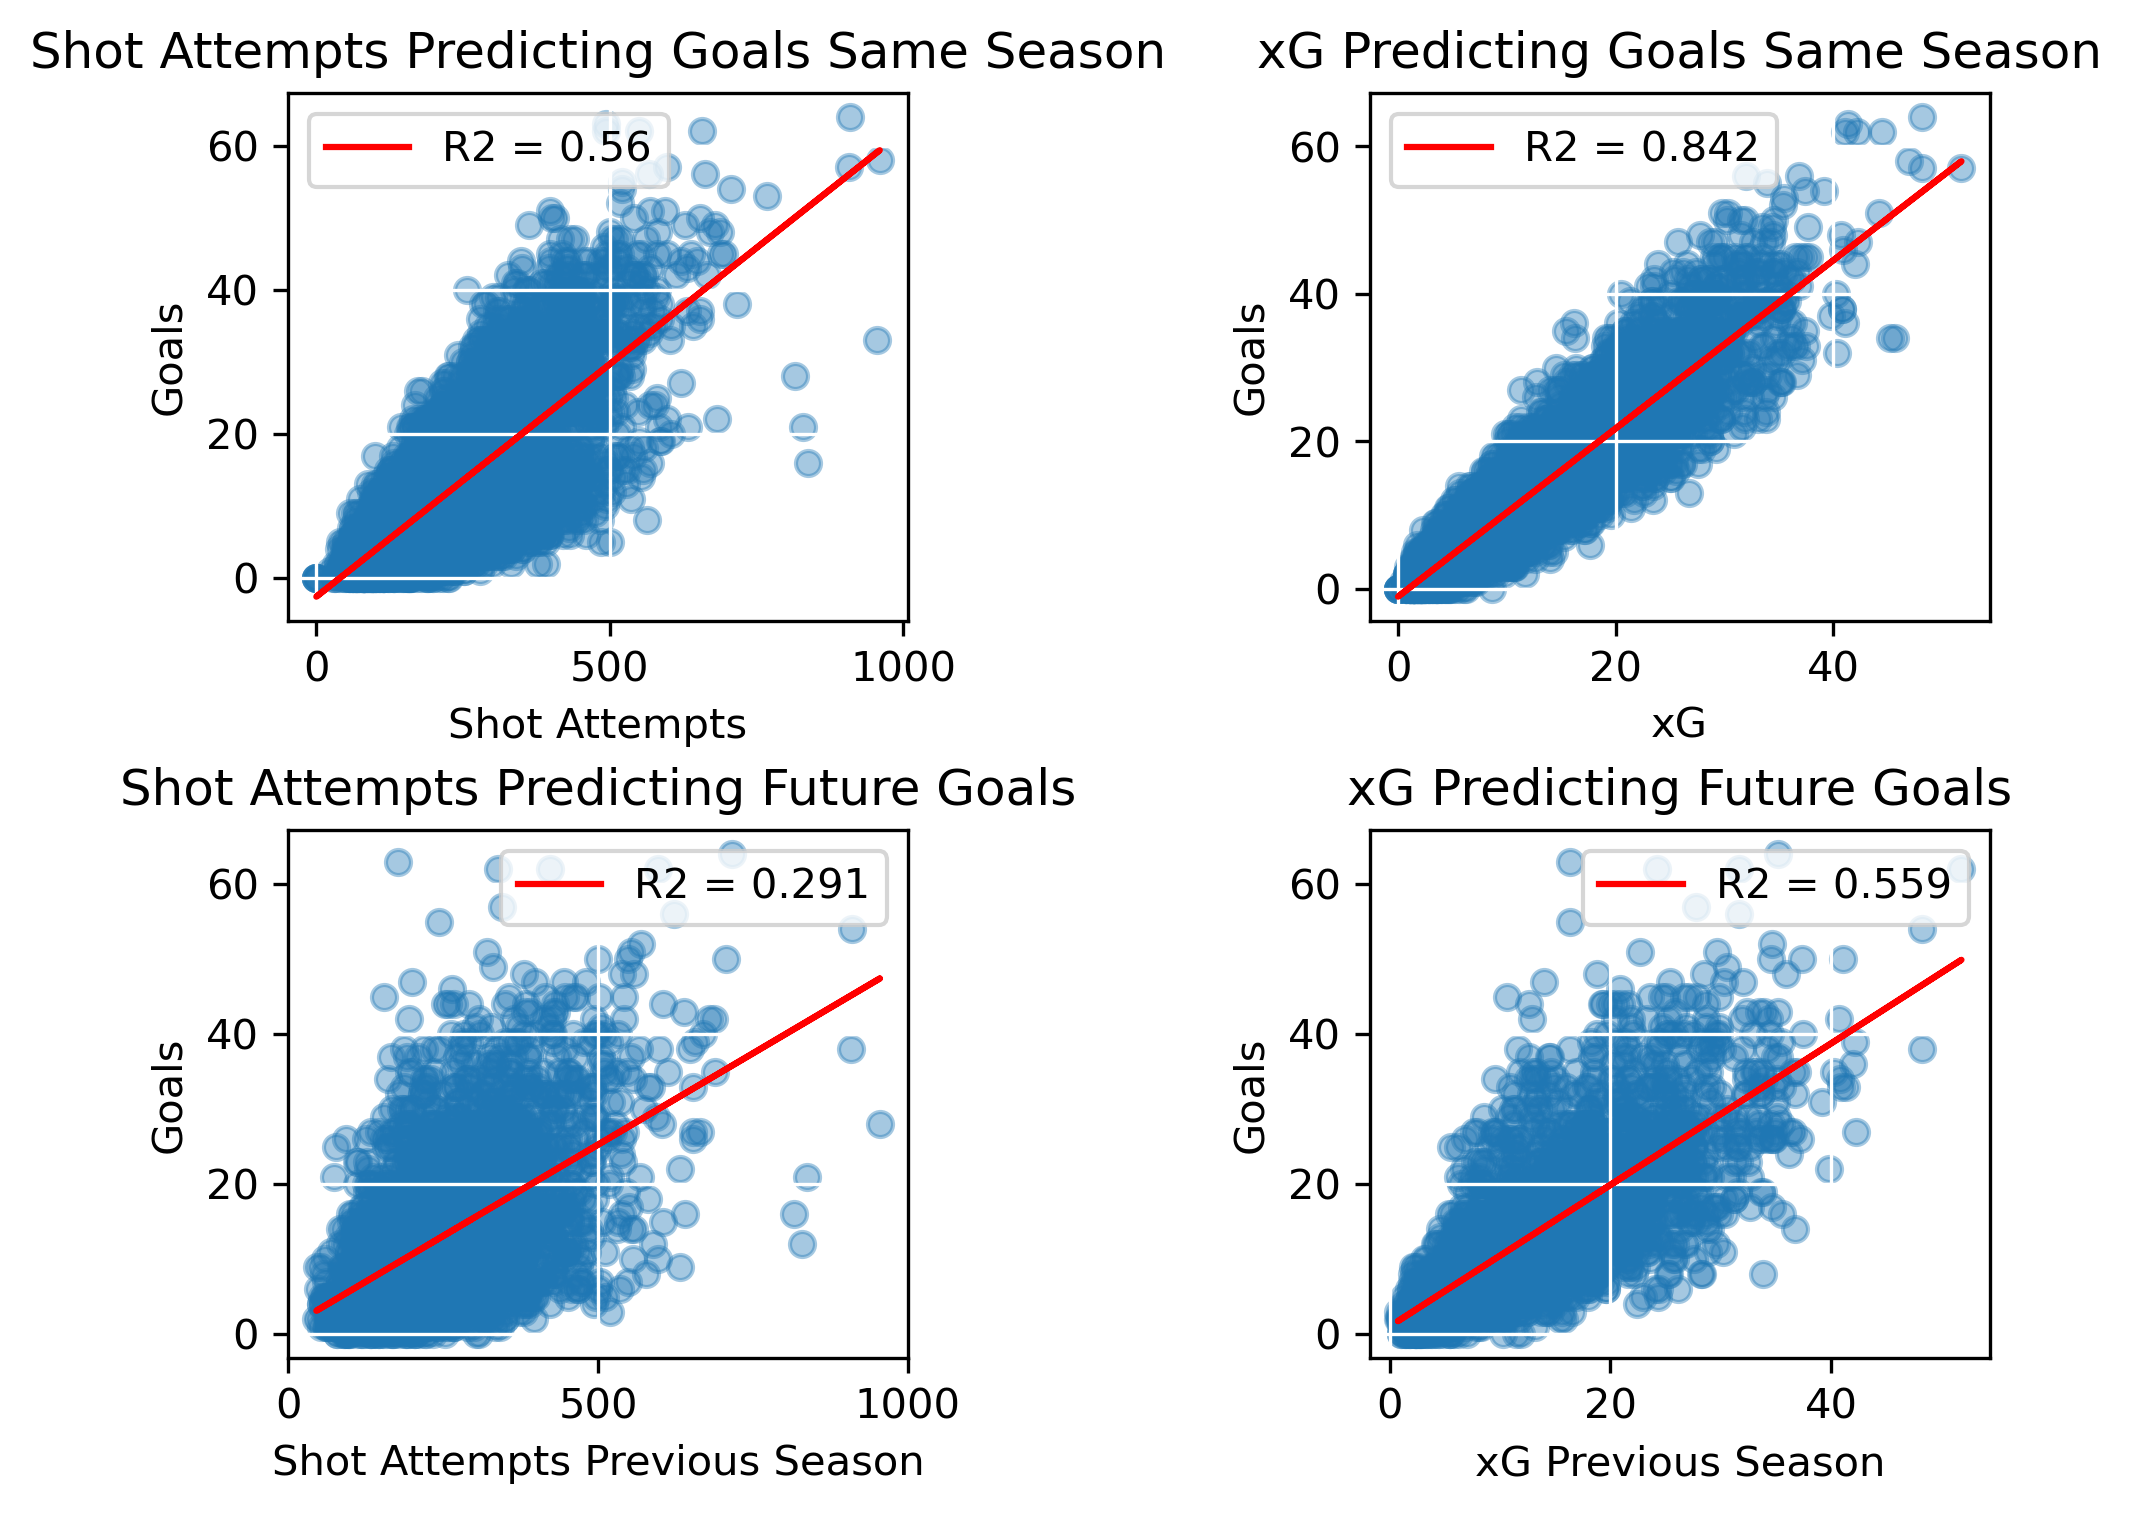

In [23]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,dpi=300)
fig.tight_layout(h_pad=3, w_pad=8)

ax1.plot(NHL_PLAYER_METRICS['Total_Shot_Attempts'], model_shot_attempts_vals, color='red', label='R2 = 0.56')
ax1.legend()
ax1.scatter(NHL_PLAYER_METRICS['Total_Shot_Attempts'], NHL_PLAYER_METRICS['Goals'], alpha =0.4)
ax1.set_title('Shot Attempts Predicting Goals Same Season')
ax1.set_ylabel('Goals')
ax1.set_xlabel('Shot Attempts')
ax1.grid(True)
ax1.grid(color='white')
      
ax2.plot(NHL_PLAYER_METRICS['xG'], model_xG_vals, color='red', label='R2 = 0.842')
ax2.legend()
ax2.scatter(NHL_PLAYER_METRICS['xG'], NHL_PLAYER_METRICS['Goals'], alpha =0.4)
ax2.set_title('xG Predicting Goals Same Season')
ax2.set_ylabel('Goals')
ax2.set_xlabel('xG')
ax2.grid(True)
ax2.grid(color='white')
      
ax3.plot(NHL_PLAYER_METRICS_pred['Total_Shot_Attempts -1'], model_shot_attempts_pred_vals, color='red', label='R2 = 0.291')
ax3.legend()
ax3.scatter(NHL_PLAYER_METRICS_pred['Total_Shot_Attempts -1'], NHL_PLAYER_METRICS_pred['Goals'], alpha =0.4)
ax3.set_title('Shot Attempts Predicting Future Goals')
ax3.set_ylabel('Goals')
ax3.set_xlabel('Shot Attempts Previous Season')
ax3.grid(True)
ax3.grid(color='white')
      
ax4.plot(NHL_PLAYER_METRICS_pred['xG -1'], model_xG_pred_vals, color='red', label='R2 = 0.559')
ax4.legend()
ax4.scatter(NHL_PLAYER_METRICS_pred['xG -1'], NHL_PLAYER_METRICS_pred['Goals'], alpha =0.4)
ax4.set_title('xG Predicting Future Goals')
ax4.set_ylabel('Goals')
ax4.set_xlabel('xG Previous Season')
ax4.grid(True)
ax4.grid(color='white')

In [ ]:
NHL_PLAYER_METRICS = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\NHL_Player_Metrics_PBP.csv")
NHL_Top_xG = NHL_PLAYER_METRICS[['Player','Player_Id', 'Season_id', 'Goals', 'xG','Actual_to_Expected_Goals','Average_Shot_Distance']]
NHL_Top_xG = NHL_Top_xG.sort_values(by='xG', ascending = False)
NHL_Top_xG.head(20)

In [11]:
NHL_Top_xG = NHL_Top_xG.sort_values(by='Actual_to_Expected_Goals', ascending = False)
NHL_Top_xG.head(20)

NameError: name 'NHL_Top_xG' is not defined

In [339]:
NHL_PLAYER_METRICS = pd.read_csv(r"C:\Users\jorda\Documents\Concordia Boot Camp\Lectures\NHL_Player_Metrics_PBP.csv")
NHL_PLAYER_METRICS

,Player,Player_Id,Season_id,Games_Played,DZ_Blocks,DZ_Faceoff_Won,DZ_Giveaways,DZ_Hits,DZ_Penalties_Taken,DZ_Takeaways,...,Actual_to_Expected_Goals_%,Average_Shot_Distance,Total_Giveaways,Total_Hits,Total_Penalties_Taken,Total_Takeaways,DZ_Faceoff_Win_Pct,NZ_Faceoff_Win_Pct,OZ_Faceoff_Win_Pct,Faceoff_Win_Pct
0,JAROMIR JAGR,8448208,2013,82,8,0,5,1,8,7,...,24,19.33654178,59,4,23,36,0.000000,0.000000,0.000000,0.000000
1,JAROMIR JAGR,8448208,2014,76,14,1,14,5,9,13,...,14,19.14041268,46,29,18,38,1.000000,0.000000,0.000000,1.000000
2,JAROMIR JAGR,8448208,2015,82,19,0,12,12,10,9,...,25,19.99423954,47,34,25,38,0.000000,0.000000,0.000000,0.000000
3,JAROMIR JAGR,8448208,2016,80,4,0,4,8,10,9,...,14,19.49203637,44,21,28,40,0.000000,0.500000,0.000000,0.500000
4,JAROMIR JAGR,8448208,2017,19,8,0,3,0,2,2,...,0,16.79416635,12,1,4,11,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942,MARCUS BJORK,8483620,2022,29,43,0,8,36,10,1,...,2,35.6931829,10,39,12,2,0.000000,0.000000,0.000000,0.000000
9943,PAVOL REGENDA,8483630,2022,13,13,0,1,4,0,0,...,0,22.00709682,5,8,2,4,0.000000,0.000000,1.000000,0.500000
9944,ANTON LEVTCHI,8483641,2022,1,0,0,1,0,0,0,...,-1,41.86884283,2,0,0,0,0.000000,0.000000,0.000000,0.000000
9945,ANDREI KUZMENKO,8483808,2022,69,18,0,6,4,3,8,...,39,15.09408155,24,13,4,30,0.000000,0.000000,0.000000,0.000000
